# Predciting Hospital Readmission

In [1]:
# Import required libraries
%matplotlib inline
import pandas as pd
import numpy as np
from fastai import*
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()

In [2]:
# Read the csv file to load the entire data
PATH = 'data/Readmissions/'

df_orig = pd.read_csv(f'{PATH}diabetic_data.csv')

Class labels were not provided specifically, they need to be computed from the "readmission" field. If>30 days or No, then we do not count that as readmission. 

We will also do a multi-class classfication wherein we will also distinguish between <30 and >30 days of readmission compared to someone who was never readmitted.

In [3]:
# Convert "readmitted" field into class label for a 2-class classification
df_orig['readmitted'] = df_orig['readmitted'].replace('<30', 1)
df_orig['readmitted'] = df_orig['readmitted'].replace('>30', 0)
df_orig['readmitted'] = df_orig['readmitted'].replace('NO', 0)

In [16]:
df_orig.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


### Data pre-processing
Now we play with the data - get our hands dirty and hopefully come out with a cleaner version of the data.
We will do the following:
1. Check for missing fields and handle missing data appropriately - if we can afford to we will try and remove all missing fields, if not we will impute using appropriate methods.
2. Convert ICD9 diagnostic codes into disease categories using LUT
3. Combine, collapse and remove some fields

In [4]:
# Handling missing data
df_orig = df_orig.replace('?', np.nan)

# Find fields with more than 70% missing data!
print(' **** Columns with more that 70% missing data ***')
print(df_orig.columns[(df_orig.count() / len(df_orig.index))<0.7])

# We are dropping columns with more than 70% missing data as imputation will not be reasonable
df = df_orig.dropna(thresh=0.7*len(df_orig.index),axis='columns')

# Also let us check how many total records we have in the data
print("Original number of records: ", len(df_orig))

# As we have large number of records, we can also try eliminating any encounter which has missing data for any field
df = df.dropna(axis='rows')

# Let us check how many records we have after removing all missing entries. 
# If the number is reasonable, we will use this cleaner data.
print("Number of records w/o any missing data : ", len(df))


 **** Columns with more that 70% missing data ***
Index(['weight', 'payer_code', 'medical_specialty'], dtype='object')
Original number of records:  101766
Number of records w/o any missing data :  98053


Converting ICD9 diagnostic codes to Diagnostic classes using LUTs. We are converting each code into 2 classes: parent class (18 classes of diseases) and subclass (each of the 18 broader specialties have sub-specialties).

For eg. code is 010
001-139 is Infectious diseases
010-018 9s Tuberculosis

So 010 will be converted to 2 categorical features "Infectious diseases" and "Tuberculosis"

In [5]:
level1_edges = pd.read_csv(f'{PATH}level1_bins.csv', header=None)
level1_edges = list(level1_edges.values.flatten())

level2_edges = pd.read_csv(f'{PATH}level2_bins.csv', header=None)
level2_edges = list(level2_edges.values.flatten())

In [6]:
# There is a special category in ICD9 that starts with V & E, we convert them to numeric to be able to bin them 
# into their respective categories. We then remove the given ICD9 codes features.

for tt in ["diag_1", "diag_2", "diag_3"]:
    t = tt + "_short"
    df[t] = df[tt]
    df[t] = df[t].replace(to_replace=r'^V.*?$', value= '1200', regex=True)
    df[t] = df[t].replace(to_replace=r'^E.*?$', value= '1200', regex=True)
    #df[t][df[t].str.startswith('V', na=False)] = '1200' 
    #df[t][df[t].str.startswith('E', na=False)] = '1200'
    df[t] = df[t].astype('float')
    df[t] = pd.np.digitize(df[t], bins=level1_edges)
    
    t = tt + "_long"
    df[t] = df[tt]
    df[t] = df[t].replace(to_replace=r'^V.*?$', value= '1200', regex=True)
    df[t] = df[t].replace(to_replace=r'^E.*?$', value= '1200', regex=True)
    #df[t][df[t].str.startswith('V', na=False)] = '1200'
    #df[t][df[t].str.startswith('E', na=False)] = '1200'
    df[t] = df[t].astype('float')
    df[t] = pd.np.digitize(df[t], bins=level2_edges)

df = df.drop(['diag_1','diag_2', 'diag_3'],axis=1)

In [7]:
meds_list = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
             'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
             'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
             'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

df_meds = df[meds_list]

# count total number of diabetes medication each patient is prescribed
df['med_count'] = df_meds[(df_meds == 'Steady') | (df_meds == 'Up') | (df_meds == 'Down')].count(axis=1)   

# count number of dose changes for all diabetes medication prescribed to each patient 
df['med_change'] = df_meds[(df_meds == 'Up') | (df_meds == 'Down')].count(axis=1)   

df = df.drop(meds_list, axis=1)

In [8]:
# Collapse number of outpatient, inpatient and emergency visits as one
df['num_visits'] = df[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)

df = df.drop(['number_outpatient', 'number_emergency', 'number_inpatient'],axis=1)

In [9]:
df['admission_type_id'] = df['admission_type_id'].replace((2, 7), 1) # all related to emergency
df['admission_type_id'] = df['admission_type_id'].replace((6, 8), 5) # not available

In [10]:
df['admission_source_id'] = df['admission_source_id'].replace((2, 3), 1) # Referrals
df['admission_source_id'] = df['admission_source_id'].replace((5, 6, 10, 18, 19, 22, 25, 26), 4) # Transfers
df['admission_source_id'] = df['admission_source_id'].replace((15, 17, 20, 21), 9) # Not available
df['admission_source_id'] = df['admission_source_id'].replace((14, 23, 24), 11) # Delivery
df['admission_source_id'] = df['admission_source_id'].replace(13, 12) # Premature/sick baby

In [11]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace((4, 12, 16, 17, 22, 27), 2) # short term care center
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace((5, 6, 8, 9, 13, 14, 15, 23, 24, 29), 3) # skilled care facility
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace((19, 20, 21), 11) # died
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace((25, 26), 18) # not available

In [12]:
#df.discharge_disposition_id.unique()

In [13]:
# Also removing encounter_id and patient_nbr
df = df.drop(['encounter_id','patient_nbr'],axis=1)

In [14]:
numerical_features = list(df.columns[df.dtypes=='int64'])
text_features = list(df.columns[df.dtypes=='object'])

categorical_features = text_features + list(['admission_type_id', 'discharge_disposition_id', 
                                             'admission_source_id', 'diag_1_short', 'diag_2_short', 
                                             'diag_3_short', 'diag_1_long', 'diag_2_long', 'diag_3_long', 
                                            'readmitted'])
continuous_features = [e for e in numerical_features if e not in categorical_features]

In [15]:
# Displaying all the features by categories
for v in categorical_features: df[v] = df[v].astype('category').cat.as_ordered()
for v in continuous_features: df[v] = df[v].astype('float')
df = df[categorical_features+continuous_features].copy()
label = df['readmitted']
df_data = df.drop('readmitted', axis=1)

print('Categorical Features : \n ', categorical_features)
print('Continuous Features : \n ',continuous_features)

Categorical Features : 
  ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1_short', 'diag_2_short', 'diag_3_short', 'diag_1_long', 'diag_2_long', 'diag_3_long', 'readmitted']
Continuous Features : 
  ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'med_count', 'med_change', 'num_visits']


In [17]:
# Saving preprocessed data
#df.to_csv(f'{PATH}cleaned_diabetic_data.csv')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

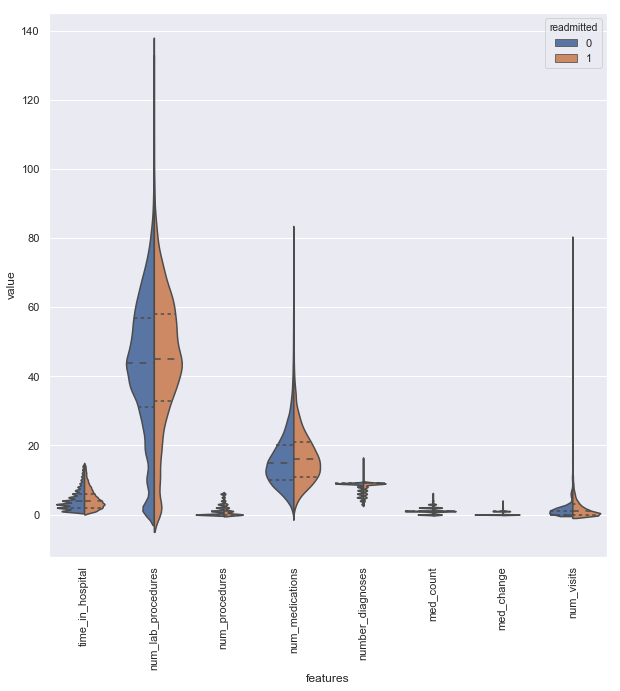

In [18]:
data_dia = df['readmitted']
data = df[continuous_features]
# data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([data_dia,data.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="readmitted",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="readmitted", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

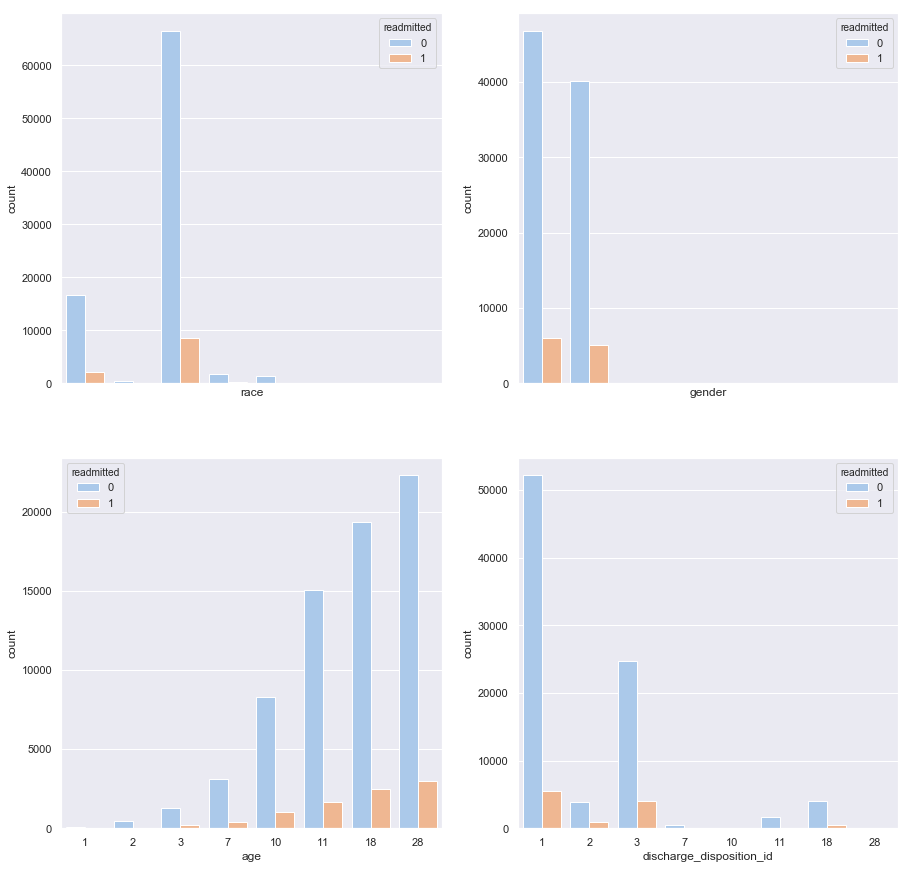

In [19]:
sns.set()
fig,axes = plt.subplots(2,2,figsize=(15,15), sharex = True)
sns.catplot(x="race", hue = "readmitted", kind="count", palette="pastel", 
            data=df[categorical_features], ax=axes[0,0])
sns.catplot(x="gender", hue = "readmitted", kind="count", palette="pastel", 
            data=df[categorical_features], ax=axes[0,1])
sns.catplot(x="age", hue = "readmitted", kind="count", palette="pastel", 
                  data=df[categorical_features], ax=axes[1,0])
sns.catplot(x="discharge_disposition_id", hue = "readmitted", kind="count", palette="pastel", 
                  data=df[categorical_features], ax=axes[1,1])
plt.tight_layout()
plt.close(2)
plt.close(3)     
plt.close(4)     
plt.close(5)     
plt.show()

In [20]:
# Splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(df_data, label, test_size = 0.20, random_state = 10,
                                                   shuffle = True, stratify = label)

In [21]:
# Transformation such as scaling for training data
df = pd.concat([X_train, Y_train], axis=1, sort=True)
df_fin, y, nas, mapper = proc_df(df, 'readmitted', do_scale=True)

In [22]:
# Checking the number of samples belonging to each class
print("Counts of label '1': {}".format(sum(Y_train==1)))
print("Counts of label '0': {} \n".format(sum(Y_train==0)))

Counts of label '1': 8853
Counts of label '0': 69589 



As classes are imbalanced, we will use a resampling method called SMOTE (Synthetic Minority Over-Sampling Technique)
to make our data set balanced.

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)

X_train_res, Y_train_res = sm.fit_sample(df_fin, y)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(Y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train_res==0)))

After OverSampling, the shape of train_X: (139178, 24)
After OverSampling, the shape of train_y: (139178,) 

After OverSampling, counts of label '1': 69589
After OverSampling, counts of label '0': 69589


# Classification using Decision Tree 

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dte = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(dte, X_train_res, Y_train_res, cv=10))))
dte.fit(X_train_res, Y_train_res)

Cross Validation score: 87.91%


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
# Transforming test data using transformations used for training data 
df = pd.concat([X_test, Y_test], axis=1, sort=True)
x_test, y_test, nas, mapper = proc_df(df, 'readmitted', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [26]:
y_test_predict = dte.predict(x_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(y_test, y_test_predict)))

Accuracy is 0.82
AUC is 0.52


In [27]:
# import graphviz
# from IPython.display import Image
# import pydotplus
# from sklearn import tree
# dot_dt_q2 = tree.export_graphviz(dte, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2, class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
# graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
# Image(graph_dt_q2.create_png())

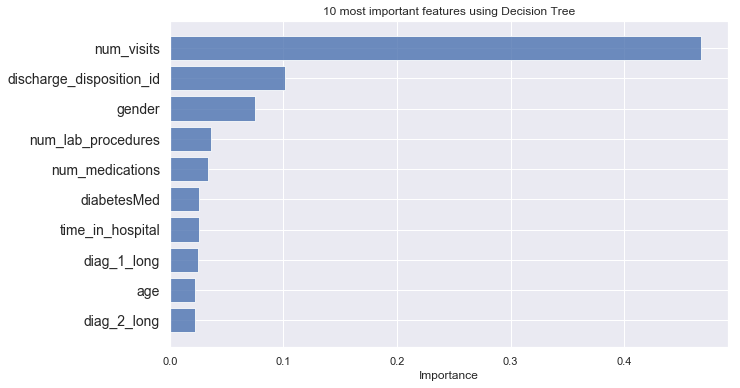

In [28]:
# Displaying top 10 most features based on importance
feature_names = X_train.columns
feature_imports = dte.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('10 most important features using Decision Tree')
plt.show()

# Classification using RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)

In [30]:
from pprint import pprint
print('Look at parameters used by our current forest')
print('Parameters currently in use:\n')
pprint(rf.get_params())

Look at parameters used by our current forest
Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


There are two generic approaches to sampling search candidates provided in scikit-learn: 

**GridSearchCV** exhaustively considers all parameter combinations, while 

**RandomizedSearchCV** can sample a given number of candidates from a parameter space with a specified distribution. This implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has the following main advantages : 

1. A budget can be chosen independent of the number of parameters and possible values.
2. Adding parameters that do not influence the performance does not decrease efficiency.

Further details regarding these procedures are [detailed here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)

To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting.
We will try adjusting the following set of hyperparameters:

1. n_estimators = number of trees in the foreset
2. max_features = max number of features considered for splitting a node
3. max_depth = max number of levels in each decision tree
4. min_samples_split = min number of data points placed in a node before the node is split
5. min_samples_leaf = min number of data points allowed in a leaf node
6. bootstrap = method for sampling data points (with or without replacement) 

### Using RandomizedSearchCV

On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2*12*2*3*3*10 = 4320 combinations, however using random search we are not trying every combination, but a varied range of combinations sampled  randomly from a wide range of values.

In [31]:
# Defining range for the hyperparameters that we will use to optimize our classifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [32]:
# Using the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_res, Y_train_res)

In [33]:
# The best parameters from fitting the random search
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 70,
 'bootstrap': True}

### Using GridSearchCV

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search.

In [34]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [1700, 1800, 1900]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
rf_grid.fit(X_train_res, Y_train_res)

# The best parameters from fitting the grid search
rf_grid.best_estimator_

Best parameters for RandomForest using gridsearchCV
{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=90, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf_best.fit(X_train_res,Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1600, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [36]:
# Get the accuracy on the test data
from sklearn import metrics
from sklearn.metrics import accuracy_score
yfit = rf_best.predict(x_test)
accu = accuracy_score(y_test, yfit)
print("Mean accuracy score: ", accu)

Mean accuracy score:  0.8873081433889144


In [37]:
# Get probability estimates for AUC computation on the test data
yprob = rf_best.predict_proba(x_test)
yprob[1:5,:]

fpr, tpr, thresholds = metrics.roc_curve(y_test,yprob[:,1])
print("AUC: ", metrics.auc(fpr,tpr))

AUC:  0.6406912834717694


Text(0.5,12.5,'Predicted label')

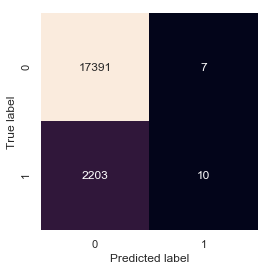

In [38]:
# Get confusion matrix for the test data
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Feature Selection

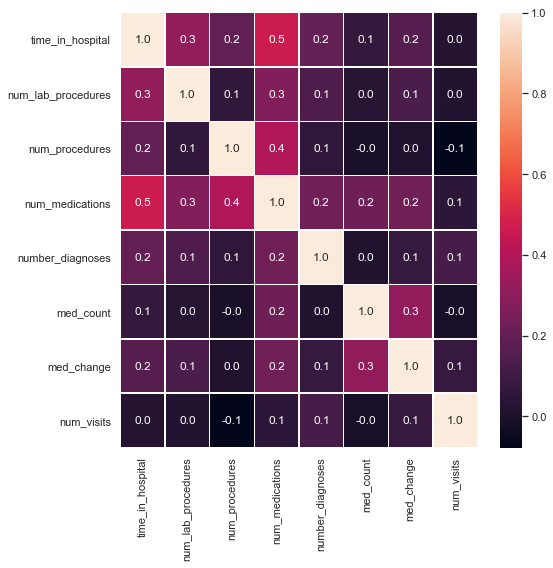

In [39]:
# Finding correlation amongst numeric features; we could prune features based on performance using correlation
x_1 = df[continuous_features]
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

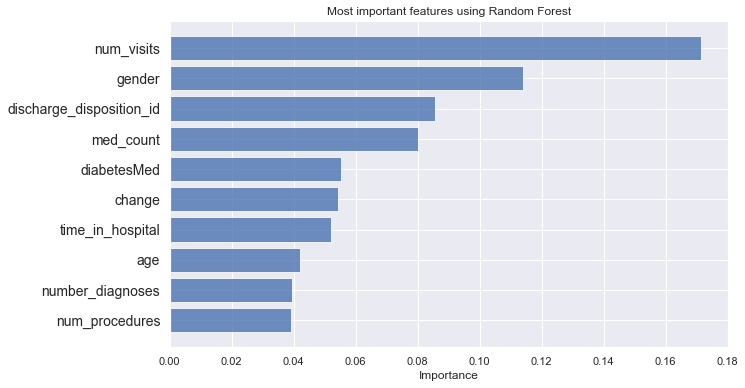

In [40]:
# Displaying top 10 most features based on importance
feature_names = X_train.columns
feature_imports = rf_best.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features using Random Forest')
plt.show()

In [41]:
#not_imp_features = [e for e in feature_names if e not in most_imp_features['Feature']]
not_imp_features = feature_names.drop(most_imp_features['Feature'])
X_train_feat_res = pd.DataFrame(X_train_res, columns=feature_names)
X_train_feat_res = X_train_feat_res.drop(not_imp_features, axis=1)

In [42]:
rf_best.fit(X_train_feat_res,Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1600, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [43]:
x_test_feat = x_test.drop(not_imp_features, axis=1)

Mean accuracy score: %d 0.886747233695375
AUC: %d 0.6195669970947313


Text(0.5,12.5,'Predicted label')

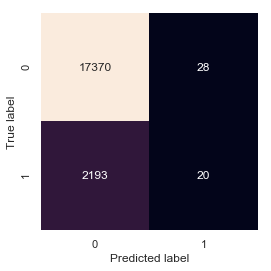

In [44]:
# Get the accuracy on the test data
yfit = rf_best.predict(x_test_feat)
accu = accuracy_score(y_test, yfit)
print("Mean accuracy score: %d", accu)

yprob = rf_best.predict_proba(x_test_feat)
yprob[1:5,:]
fpr, tpr, thresholds = metrics.roc_curve(y_test,yprob[:,1])
print("AUC: %d", metrics.auc(fpr,tpr))

mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1600, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

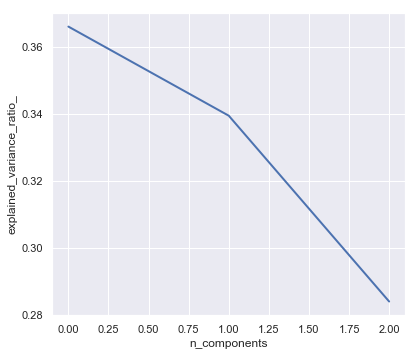

In [50]:
# feature selection using PCA decomposition on training dataset (w/o resampling)

from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit(X_train_res)

plt.figure(1, figsize=(7, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

X_new = pca.transform(X_train_res)
rf_best.fit(X_new,Y_train_res)

Mean accuracy score: %d 0.7398908775687114
AUC: %d 0.5174953496947958


Text(0.5,12.5,'Predicted label')

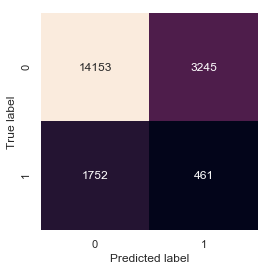

In [51]:
yfit = rf_best.predict(pca.transform(x_test))
accu = accuracy_score(Y_test, yfit)
print("Mean accuracy score: %d", accu)

yprob = rf_best.predict_proba(pca.transform(x_test))
yprob[1:5,:]
fpr, tpr, thresholds = metrics.roc_curve(y_test,yprob[:,1])
print("AUC: %d", metrics.auc(fpr,tpr))

mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')